In [1]:
import gzip
import pickle

import sys, os
from os import path

import time
import numpy as onp

import jax
from jax.lax import scan, cond
from jax import random, flatten_util
import jax.numpy as np
from jax import vjp, custom_vjp, jacfwd, jacrev, vmap
from functools import partial
import openTSNE
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return onp.ma.masked_array(onp.interp(value, x, y))
    
def load_data(n_samples=None):
    with gzip.open(path.join("examples/data/mnist", "mnist.pkl.gz"), "rb") as f:
        data = pickle.load(f)

    x, y = data["pca_50"], data["labels"]

    if n_samples is not None:
        indices = onp.random.choice(
            list(range(x.shape[0])), n_samples, replace=False
        )
        x, y = x[indices], y[indices]

    return x, y

def compute_importances_per_sample(jacobian):
    jacobian_sum_per_sample = []
    jacobian_sum = np.sum(np.abs(jacobian), axis=0)
    for i in range(n):
        sum_for_sample = []
        for j in range(p):
            sum_for_sample.append(jacobian_sum[j*n+i])
        jacobian_sum_per_sample.append(sum(sum_for_sample))
    return jacobian_sum_per_sample

def HdiffGreaterTrue(*betas):
    beta, betamax = betas
    return beta*2

def HdiffGreaterFalse(*betas):
    beta, betamax = betas
    return (beta+betamax)/2

def HdiffSmallerTrue(*betas):
    beta, betamin = betas
    return beta/2

def HdiffSmallerFalse(*betas):
    beta, betamin = betas
    return (beta+betamin)/2

def HdiffGreater(*betas):
    beta, betamin, betamax = betas
    betamin = beta
    beta = cond((np.logical_or(betamax == np.inf, betamax == -np.inf)), HdiffGreaterTrue, HdiffGreaterFalse, *(beta, betamax))
    return beta, betamin, betamax

def HdiffSmaller(*betas):
    beta, betamin, betamax = betas
    betamax = beta
    beta = cond(np.logical_or(betamin == np.inf, betamin == -np.inf), HdiffSmallerTrue, HdiffSmallerFalse, *(beta, betamin))
    return beta, betamin, betamax

def HdiffGreaterTolerance(*betas):
    beta, betamin, betamax, Hdiff = betas
    beta, betamin, betamax = cond(Hdiff > 0, HdiffGreater, HdiffSmaller, *(beta, betamin, betamax))
    return beta, betamin, betamax, Hdiff


def pca(X: np.ndarray, no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """
    print("Preprocessing the data using PCA...")
    #(n, d) = X.shape
    X = X - np.mean(X, axis=0)
    u, s, vh = np.linalg.svd(X, full_matrices=False, compute_uv=True, hermitian=False)
    #l = (s ** 2 / (d))[0:no_dims]
    M = vh[0:no_dims, :]
    Y = np.dot(X, M.T)
    return Y

def logSoftmax(x):
    """Compute softmax for vector x."""
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x)
    log_sum_exp_x = np.log(sum_exp_x)
    max_plus_log_sum_exp_x = max_x + log_sum_exp_x
    log_probs = x - max_plus_log_sum_exp_x

    # Recover probs
    exp_log_probs = np.exp(log_probs)
    sum_log_probs = np.sum(exp_log_probs)
    probs = exp_log_probs / sum_log_probs
    return probs


def Hbeta(D: np.ndarray, beta=1.0):
    """
    Compute the log2(perplexity)=Entropy and the P-row (P_i) for a specific value of the
        precision=1/(sigma**2) (beta) of a Gaussian distribution. D: vector of squared Euclidean distances (without i)
    :param D: vector of length d, squared Euclidean distances to all other datapoints (except itself)
    :param beta: precision = beta = 1/sigma**2
    :return: H: log2(Entropy), P: computed probabilites
    """
    # TODO: exchange by softmax as described by https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/
    P = np.exp(-D * beta)     # numerator of p j|i
    sumP = np.sum(P, axis=None)    # denominator of p j|i --> normalization factor
    new_P = logSoftmax(-D * beta)
    sumP += 1e-8
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    return H, new_P

def binarySearch(res, el, Di, logU):
    print('Entered binary search function')
    Hdiff, thisP, beta, betamin, betamax = res
    Hdiffbool = np.abs(Hdiff) < 1e-5
    beta, betamin, betamax, Hdiff = cond(np.abs(Hdiff) < 1e-5, lambda a, b, c, d: (a, b, c, d), HdiffGreaterTolerance, *(beta, betamin, betamax, Hdiff))

    (H, thisP) = Hbeta(Di, beta)
    Hdiff = H - logU
    return (Hdiff, thisP, beta, betamin, betamax), el

def x2p_inner(Di: np.ndarray, iterator, beta, betamin, betamax, perplexity=30, tol=1e-5):
    """
    binary search for precision for Pi such that it matches the perplexity defined by the user
    :param Di: vector of length d-1, squared Euclidean distances to all other datapoints (except itself)
    :param beta: precision = beta = 1/sigma**2
    :return: final probabilites p j|i
    """
    # Compute the Gaussian kernel and entropy for the current precision
    logU = np.log(perplexity)
    H, thisP = Hbeta(Di, beta)
    Hdiff = H - logU

    print('Starting binary search')
    binarySearch_func = partial(binarySearch, Di=Di, logU=logU)

    # Note: the following binary Search for suitable precisions (betas) will be repeated 50 times and does not include the threshold value
    (Hdiff, thisP, beta, betamin, betamax), el = scan(binarySearch_func, init=(Hdiff, thisP, beta, betamin, betamax), xs=None, length=50)    # Set the final row of P
    thisP = np.insert(thisP, iterator, 0)
    return thisP

def x2p(X: np.ndarray, tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values (high-dim space) in such a way that each
        conditional Gaussian has the same perplexity.
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    D = np.reshape(np.delete(D, np.array([i for i in range(0, D.shape[0]**2, (D.shape[0]+1))])), (n , n - 1 ))
    beta = np.ones(n)      # precisions (1/sigma**2)
    betamin = np.full(n, -np.inf)
    betamax = np.full(n, np.inf)
    P = vmap(partial(x2p_inner, perplexity=perplexity, tol=tol))(D, np.arange(n), beta=beta, betamin=betamin, betamax=betamax)
    return P

def y2q(Y: np.ndarray):
    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)  # numerator
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    num = num.at[np.diag_indices_from(num)].set(0.)     # numerator
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)
    return Q

def optimizeY(res, el, P, initial_momentum=0.5, final_momentum=0.8, eta=500, min_gain=0.01, exaggeration=4.):
    Y, iY, gains, i = res
    n, d = Y.shape

    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)  # numerator
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    num = num.at[np.diag_indices_from(num)].set(0.)     # numerator
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)


    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = Y_diffs * num_exp
    grad = np.sum((PQ_exp * Y_diffs_wt), axis=1) # Nx2

    # Update Y
    momentum = cond(i<250, lambda: initial_momentum, lambda: final_momentum)
    # this business with "gains" is the bar-delta-bar heuristic to accelerate gradient descent
    # code could be simplified by just omitting it
    #inc = iY * grad > 0
    #dec = iY * grad < 0
    #gains = np.where((iY * grad > 0), gains+0.2, gains)
    #gains = np.where((iY * grad < 0), gains*0.8, gains)
    gains = np.clip(gains, min_gain, np.inf)

    iY = momentum * iY - eta * (gains * grad)
    Y = Y + iY

    Y = Y - np.mean(Y, axis=0)
    P = cond(i==100, lambda x: x/exaggeration, lambda x:x, P)
    i += 1
    return ((Y, iY, gains, i), 1.0)

def optimizeYforBackprob(res, el, P, initial_momentum=0.8, final_momentum=0.5, eta=500, min_gain=0.01):
    Y, iY, gains, i = res
    n, d = Y.shape

    # Compute pairwise affinities
    sum_Y = stop_gradient(np.sum(np.square(Y), 1))
    num = stop_gradient(-2. * np.dot(Y, Y.T))  # numerator
    num = stop_gradient(1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y)))
    num = stop_gradient(num.at[np.diag_indices_from(num)].set(0.))     # numerator
    Q = stop_gradient(num / np.sum(num))
    Q = stop_gradient(np.maximum(Q, 1e-12))


    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = stop_gradient(np.expand_dims(Y, 1) - np.expand_dims(Y, 0))  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = stop_gradient(Y_diffs * num_exp)
    grad = np.sum((PQ_exp * Y_diffs_wt), axis=1) # Nx2

    # Update Y
    momentum = cond(i<20, lambda: initial_momentum, lambda: final_momentum)
    # this business with "gains" is the bar-delta-bar heuristic to accelerate gradient descent
    # code could be simplified by just omitting it
    # inc = iY * grad > 0
    # dec = iY * grad < 0
    # gains = np.where((iY * grad > 0), gains+0.2, gains)
    # gains = np.where((iY * grad < 0), gains*0.8, gains)
    gains = np.clip(gains, min_gain, np.inf)

    iY = momentum * iY - eta * (gains * grad)
    Y = Y + iY

    Y = Y - np.mean(Y, axis=0)
    P = cond(i==250, lambda x: x/12., lambda x:x, P)
    i += 1
    return ((Y, iY, gains, i), 1.0)

def tsne(X: np.ndarray, no_dims=2, initial_dims=50, perplexity=30.0, learning_rate=500, max_iter = 1000, exaggeration=4., key=42):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    #X = pca(X, initial_dims)
    (n, d) = X.shape
    key = random.PRNGKey(key)

    initial_momentum = 0.8
    final_momentum = 0.5
    eta = learning_rate   # Initial learning rate
    min_gain = 0.01
    # Initialize solution
    #if init is not None:
    #    Y = init
    #else:
    #    Y = random.normal(key, shape=(n, no_dims))
    Y = random.normal(key, shape=(n, no_dims))
    dY = np.zeros((n, no_dims))
    #Y_t1 = np.zeros((n, no_dims))
    #Y_t2 = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)    # I don't know if the computed P is correct np.sum(P, axis=0) is not 1 everywhere
    P = (P + np.transpose(P))

    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = P * exaggeration  # early exaggeration
    P = np.maximum(P, 1e-12)

    # for debugging
    #for i in range(1000):
    #  ((P, Y, dY, iY, gains, i), j) = optimizeY((P, Y, dY, iY, gains, i), el=1, initial_momentum = initial_momentum, final_momentum = final_momentum, eta = eta, min_gain = min_gain)


    # jit-compiled version
    optimizeY_func = partial(optimizeY, P=P, initial_momentum = initial_momentum, final_momentum = final_momentum, eta = eta, min_gain = min_gain, exaggeration = exaggeration)
    ((Y, iY, gains, i), el) = scan(optimizeY_func, init=(Y, iY, gains, 0), xs=None, length=max_iter)  # Set the final row of P
    return Y

In [3]:
def load_data(n_samples=None):
    with gzip.open(path.join("examples/data/mnist", "mnist.pkl.gz"), "rb") as f:
        data = pickle.load(f)

    x, y = data["pca_50"], data["labels"]

    if n_samples is not None:
        indices = onp.random.choice(
            list(range(x.shape[0])), n_samples, replace=False
        )
        x, y = x[indices], y[indices]

    return x, y

In [4]:
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    Q = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [5]:
def Hessian_y_y(f, X, Y):
    '''
    nxp, nx2 --> 2n x 2n
    '''
    X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
    Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y)   # row-wise
    H = jax.hessian(f, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)
    ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(H-np.diag(np.diag(H)), cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(H-np.diag(np.diag(H))), vmax=onp.max(H-np.diag(np.diag(H))))))
    ax.set_title('Hessian df/dydy')
    return H

def Mixed_Jacobian_x_y(f, X, Y):
    '''
    Symmetry of mixed partials (order of derivatives doesn't matter)
    nxp, nx2 --> 2n x np
    '''    
    X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
    Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y)   # row-wise
    
    #J_X_Y = jacrev(jacfwd(f, argnums=0), argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)
    J_X_Y = jacfwd(jacfwd(f, argnums=1), argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener)
    ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(J_X_Y, cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(J_X_Y), vmax=onp.max(J_X_Y))))
    ax.set_title('Jacobian df/dydx')
    return J_X_Y

def d_y_star_d_x(H, J):
    lu, piv= jax.scipy.linalg.lu_factor(H)
    return jax.scipy.linalg.lu_solve((lu, piv), -J)

def d_y_star_d_x_outer(f, X, Y_star):
    return d_y_star_d_x(Hessian_y_y(KL_divergence, X, Y_star), Mixed_Jacobian_x_y(KL_divergence, X, Y_star))
    

In [6]:
def fixed_point(x, y_guess):
    affinity = openTSNE.affinity.PerplexityBasedNN(
        x,
        perplexity=30.0,
        method="annoy",
        random_state=42,
        verbose=True,
    )

    init = openTSNE.initialization.random(
        x, n_components=2, random_state=42, verbose=True,
    )
    
    y_star = openTSNE.TSNEEmbedding(
        init,
        affinity,
        learning_rate=200,
        negative_gradient_method="fft",
        random_state=42,
    )
    y_star.optimize(250, exaggeration=12, momentum=0.8, inplace=True)
    y_star.optimize(750, momentum=0.5, inplace=True)
    return y_star

In [7]:
X, labels = load_data(50)
X = X[onp.argsort(labels)]
key = random.PRNGKey(42)
y_guess = random.normal(key, shape=(X.shape[0], 2))
Y_star = fixed_point(X, y_guess)

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds


Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 4 4 5 5 6 6 6 6 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8]


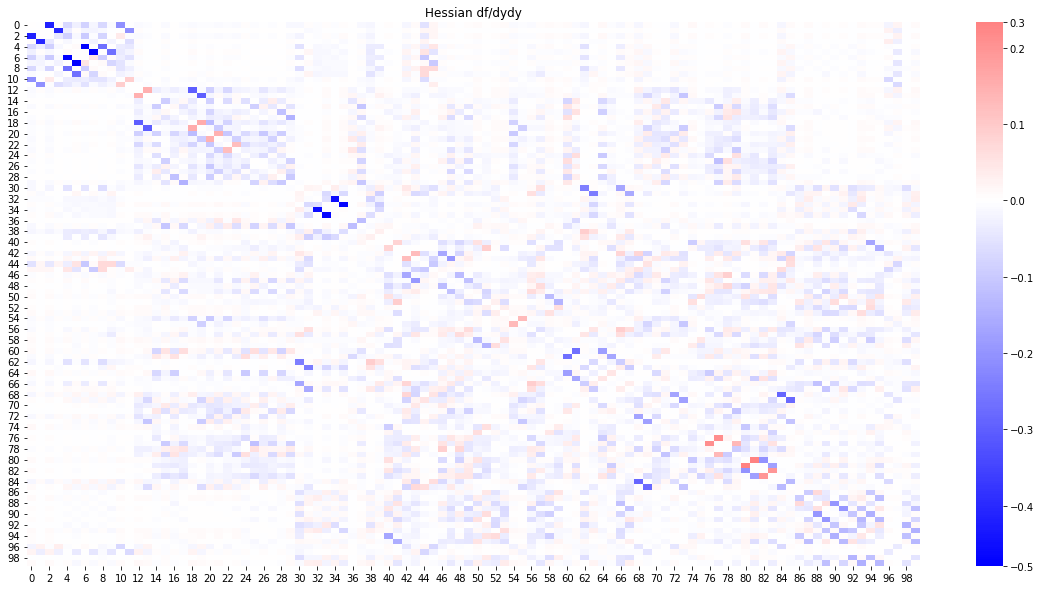

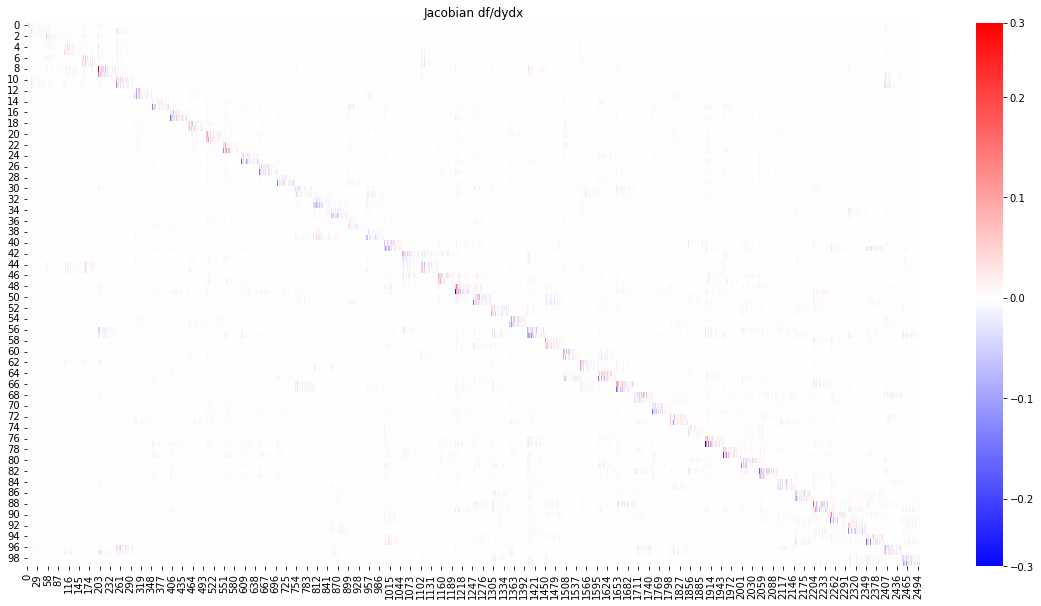

In [8]:
dy = d_y_star_d_x_outer(KL_divergence, X, Y_star)
print(labels[onp.argsort(labels)])

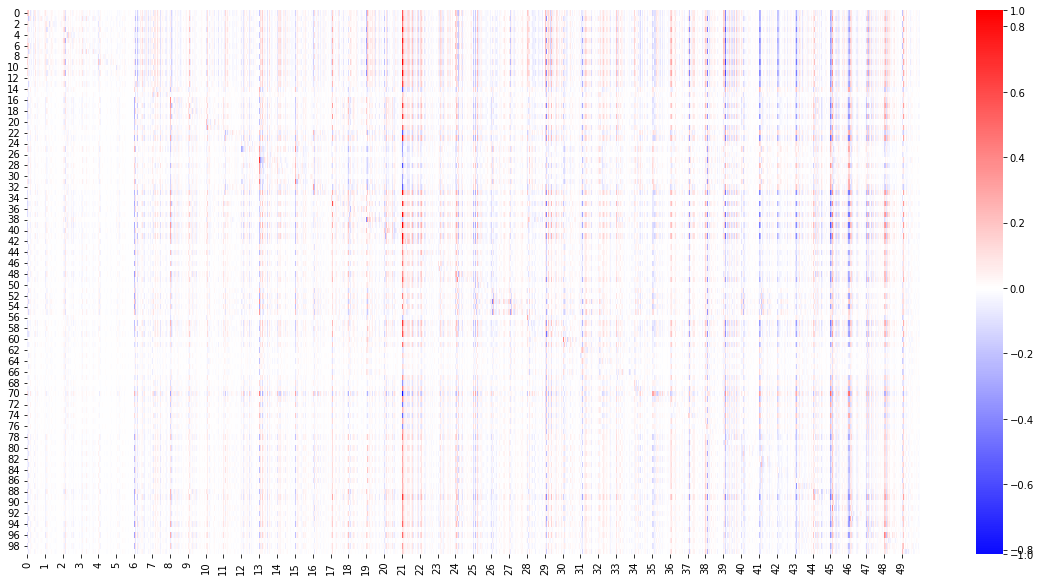

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(dy, cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(dy), vmax=onp.max(dy))))
ax.set_xticks(np.arange(0, X.shape[0]*X.shape[1], X.shape[1]), labels=[str(i) for i in range(X.shape[1])]);

In [25]:
X = np.array([[1., 2., 4., 5.], [3., 4., 5., 7.], [5., 6., 10., -5]])
Y = np.array([[5., 10.], [1., 2.], [3., 4.]])
H = Hessian_y_y(KL_divergence, X, Y)
J_X_Y = Mixed_Jacobian_x_y(KL_divergence, X, Y)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [36]:
dy = d_y_star_d_x(H, J_X_Y)

In [53]:
H_test = jax.hessian(KL_divergence, argnums=1)(X, Y, lambda x: x, lambda x: x)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [54]:
J_test = jacfwd(jacfwd(KL_divergence, argnums=1), argnums=0)(X, Y, lambda x: x, lambda x: x)

Computing pairwise distances...
Starting binary search
Entered binary search function
